# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Мне Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. В моём распоряжении исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры. 


# 1. Подготовка данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В таблице есть пропущенные значения в столбце Tenure. Также, необходимо поменять тип данных этого столбца на целочисленный 

In [3]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


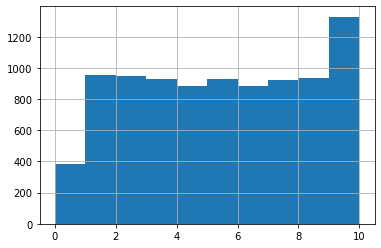

In [4]:
#Построим гистограаму столбца Tenure.
data['Tenure'].hist(bins=10)

На гистограмме видно, что меньше всего значений ноля, соответственно 10% пропущенных значений можно заполнить 0.

In [5]:
data['Tenure'] = data['Tenure'].fillna(value = 0)
#Приведем тип данных столбца Tenure к целочисленному
data['Tenure'] = data['Tenure'].astype('int64')
data['Balance'] = data['Balance'].astype('int64')
data['EstimatedSalary'] = data['EstimatedSalary'].astype('int64')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   RowNumber        10000 non-null  int64 
 1   CustomerId       10000 non-null  int64 
 2   Surname          10000 non-null  object
 3   CreditScore      10000 non-null  int64 
 4   Geography        10000 non-null  object
 5   Gender           10000 non-null  object
 6   Age              10000 non-null  int64 
 7   Tenure           10000 non-null  int64 
 8   Balance          10000 non-null  int64 
 9   NumOfProducts    10000 non-null  int64 
 10  HasCrCard        10000 non-null  int64 
 11  IsActiveMember   10000 non-null  int64 
 12  EstimatedSalary  10000 non-null  int64 
 13  Exited           10000 non-null  int64 
dtypes: int64(11), object(3)
memory usage: 1.1+ MB


В нашей таблице, на мой взгляд есть лишние столбцы, которые могут ухудшить обучение моделей. Это столбцы CustomerId и Surname. Их можно удалить


In [7]:
data_drop = data.drop(columns=['CustomerId', 'Surname', 'RowNumber'])
data_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CreditScore      10000 non-null  int64 
 1   Geography        10000 non-null  object
 2   Gender           10000 non-null  object
 3   Age              10000 non-null  int64 
 4   Tenure           10000 non-null  int64 
 5   Balance          10000 non-null  int64 
 6   NumOfProducts    10000 non-null  int64 
 7   HasCrCard        10000 non-null  int64 
 8   IsActiveMember   10000 non-null  int64 
 9   EstimatedSalary  10000 non-null  int64 
 10  Exited           10000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 859.5+ KB


In [8]:
#Построим матрицу корреляций
corr = data.corr()
corr.style.background_gradient(cmap='cool').set_precision(3)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000,0.004,0.006,0.001,0.001,-0.009,0.007,0.001,0.012,-0.006,-0.017
CustomerId,0.004,1.000,0.005,0.009,-0.016,-0.012,0.017,-0.014,0.002,0.015,-0.006
CreditScore,0.006,0.005,1.000,-0.004,0.003,0.006,0.012,-0.005,0.026,-0.001,-0.027
Age,0.001,0.009,-0.004,1.000,-0.007,0.028,-0.031,-0.012,0.085,-0.007,0.285
Tenure,0.001,-0.016,0.003,-0.007,1.000,-0.006,0.010,0.021,-0.026,0.011,-0.013
Balance,-0.009,-0.012,0.006,0.028,-0.006,1.000,-0.304,-0.015,-0.010,0.013,0.119
NumOfProducts,0.007,0.017,0.012,-0.031,0.010,-0.304,1.000,0.003,0.010,0.014,-0.048
HasCrCard,0.001,-0.014,-0.005,-0.012,0.021,-0.015,0.003,1.000,-0.012,-0.010,-0.007
IsActiveMember,0.012,0.002,0.026,0.085,-0.026,-0.010,0.010,-0.012,1.000,-0.011,-0.156
EstimatedSalary,-0.006,0.015,-0.001,-0.007,0.011,0.013,0.014,-0.010,-0.011,1.000,0.012


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Классная тепловая карта 👍
    
В том числе мы можем использовать метод `heatmap` из библиотеки `seaborn`. 
    
</div>

Мы видм, что у данных нет высокой корреляции друг с другом.

In [9]:
#Преобразуем категориальные признаки в численные
data_ohe = pd.get_dummies(data_drop, drop_first=True)


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Лучше всего явным образом указывать категориальные переменные в методе `get_dummies`, чтобы случайным образом не создать дополнительные не нужные переменные.    
</div>

In [10]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0,1,1,1,101348,1,0,0,0
1,608,41,1,83807,1,0,1,112542,0,0,1,0
2,502,42,8,159660,3,1,0,113931,1,0,0,0
3,699,39,1,0,2,0,0,93826,0,0,0,0
4,850,43,2,125510,1,1,1,79084,0,0,1,0


In [11]:
#Разобьём наш датафрейм на тренировочную (60%) и промежуточную (40%) валидационную выборку 
#Разобьём промежуточную (40%) валидационную выборку на валидационную итестовую выюорки соответственно
data_train, data_valid_inter = train_test_split(data_ohe, test_size=0.4, random_state=12345)
data_valid, data_test = train_test_split(data_valid_inter, test_size=0.5, random_state=12345)

In [12]:
#Проверим, что всё разбилось правильно
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(6000, 12)
(2000, 12)
(2000, 12)


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>
    
В целом выборка разделена верно.
    
Я бы рекомендовал бы ещё использовать атрибут `stratify` для целевой переменной. Он дает нам безопасность сохранения 20% значений равного нужного нам количества классов в целевой переменной.
    
В том числе бывает полезен атрибут `shuffle` , он перемешивает наши выборки случайным образом, так мы подстарховываем себя от случаных закономерностей в данных.
    
</div>

In [13]:
features_train = data_train.drop(['Exited'], axis=1)
target_train = data_train['Exited']
features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited']
features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']

In [14]:
#Масштабируем численные признаки методом стандартизации
numeric = ['CreditScore', 'Age', 'Balance', 'Tenure', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
display(features_train.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.104696,1.232268,1,1,0,-0.187698,0,1,1
3411,0.608663,-0.183385,1.104696,0.600556,1,0,0,-0.333940,0,0,0
6027,2.052152,0.480939,-0.503694,1.027096,2,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.461340,-1.233162,2,1,0,-1.071058,0,0,1
3716,0.130961,-1.132419,-0.825373,1.140469,1,0,0,1.524276,1,0,0


<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>

Рекомендую не применять метод `print()` для вывода таблиц. Лучше импортировать в
начале проекта метод `display` из библиотеки `IPython.display` и
применять его:

---
    
`from IPython.display import display`

`display(df)`

    
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Хорошо, что масштабируем наши данные. Так модель в большинстве случаев работает лучше, но это не всегда и нужно проверять.
    
---
    
В том числе я бы рекомендовал построить графики распределения наших данных, чтобы поверхностно понимать с чем мы имеем дело перед нормализацией и после соответственно.

И посмотреть на матрицу корреляции, ведь у нас могут быть признаки, которые сильно коррелируют с таргет перменной, а это может отрицательно сказаться на нашей моделе. Хотел бы отметить, что так бывает не постоянно и эти способы стоит тестировать.
    
</div>

# 2. Исследование задачи

###### 2.1. Проверка баланса классов

0    0.7963
1    0.2037
Name: Exited, dtype: float64


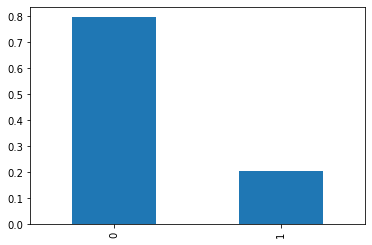

In [15]:
#Посмотрим на соотношение меток классов в столбце Exited
class_frequency = data['Exited'].value_counts(normalize=bool)
print(class_frequency)
class_frequency.plot(kind='bar')

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Дисбаланс на лицо.
    
</div>

Мы видим, что нулей 80%, а единиц 20%, соответсвтенно наблюдается дисбаланс классов

###### 2.2. Исследуем первую модель: Случайный лес

In [16]:
%%time
best_model = None
best_result = 0
for est in range(1, 60):
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid) 
        if result > best_result:
            best_model = model
            best_result = result
print("f1-мера наилучшей модели на валидационной выборке:", best_result)
print('Параметры лучшей модели:', best_model)

f1-мера наилучшей модели на валидационной выборке: 0.5818181818181819
Параметры лучшей модели: RandomForestClassifier(max_depth=9, n_estimators=8, random_state=12345)
Wall time: 1min 19s


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Хорошие показатели для первого расчета 👍 
    
Здорово, что используешь много несколько гиперпараметров. 
</div>

###### 2.3. Исследуем первую модель: Решающее дерево

In [17]:
%%time
best_model = None
best_result = 0
for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_model = model
        best_result = result
print("f1-мера наилучшей модели на валидационной выборке:", best_result)
print('Параметры лучшей модели:', best_model)

f1-мера наилучшей модели на валидационной выборке: 0.5786516853932585
Параметры лучшей модели: DecisionTreeClassifier(max_depth=9, random_state=12345)
Wall time: 451 ms


###### 2.4. Исследуем третью модель: Логистическая регрессия

In [18]:
model = LogisticRegression(random_state=12345) 
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
result = f1_score(target_valid, predicted_valid)
print("f1-мера модели на валидационной выборке:", result)

f1-мера модели на валидационной выборке: 0.33389544688026984


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

В том числе можно было попробвать и сравнить параметр `C` у логистической регрессии. 
    
---
    
Кстати для автоматического перебора гиперпараметров мы можем использовать готовый метод `GreadSearchCV` в библиотеке `sklearn`. 
    
</div>

###### 2.5. Проверка наилучшей модели на тестовой выборке

In [19]:
model = RandomForestClassifier(random_state=12345, n_estimators=8, max_depth=9) 
model.fit(features_train, target_train) 
predicted_test = model.predict(features_test)
result = f1_score(target_test, predicted_test) 
print(result)

0.5062111801242236


#####  2.6. Вывод

Лучше всего себя показала модель случайного леса. F1-мера этой модели: 0.5062, при максимальной глубине - 9, n_estimators=8. Полученное значение F1-меры не удовлетворяет условию проекта. Так как в п 2.1 мы выяснили, что у нас присутствует дисбаланс классов, то необходимо минимизировать вляение этого дисбаланса на получаемый результат.

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Можно кстати использовать бОльшее количество деревьев 100–150, срезать мы всегда успеем.     
</div>

# 3. Борьба с дисбалансом

##### 3.1. Балансировка веса классов

In [20]:
%%time
#Случайный лес
best_model = None
best_result = 0
for est in range(1, 60):
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid) 
        if result > best_result:
            best_model = model
            best_result = result
print("f1-мера наилучшей модели на валидационной выборке:", best_result)
print('Параметры лучшей модели:', best_model)

f1-мера наилучшей модели на валидационной выборке: 0.6261261261261261
Параметры лучшей модели: RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=31,
                       random_state=12345)
Wall time: 1min 9s


In [21]:
%%time
#Логистическая регрессия
model = LogisticRegression(random_state=12345, class_weight='balanced') 
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
result = f1_score(target_valid, predicted_valid)
print("f1-мера модели на валидационной выборке:", result)

f1-мера модели на валидационной выборке: 0.4888888888888888
Wall time: 28.9 ms


In [22]:
%%time
#Решающее дерево
best_model = None
best_result = 0
for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_model = model
        best_result = result
print("f1-мера наилучшей модели на валидационной выборке:", best_result)
print('Параметры лучшей модели:', best_model)

f1-мера наилучшей модели на валидационной выборке: 0.5786516853932585
Параметры лучшей модели: DecisionTreeClassifier(max_depth=9, random_state=12345)
Wall time: 422 ms


##### Вывод

f1-мера наилучшей модели (случайный лес): 0.630225080385852
Параметры лучшей модели: RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=55, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

### Upsampling

In [23]:
%%time
#Применим функция для увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)
best_model = None
best_result = 0
for est in range(1, 60):
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid) 
        if result > best_result:
            best_model = model
            best_result = result
print("f1-мера наилучшей модели на валидационной выборке:", best_result)
print('Параметры лучшей модели:', best_model)


f1-мера наилучшей модели на валидационной выборке: 0.5368821292775665
Параметры лучшей модели: RandomForestClassifier(max_depth=9, n_estimators=36, random_state=12345)
Wall time: 2min 6s


In [24]:
#Логистическая регрессия
model = LogisticRegression(random_state=12345, class_weight='balanced') 
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
result = f1_score(target_valid, predicted_valid)
print("f1-мера модели на валидационной выборке:", result)

f1-мера модели на валидационной выборке: 0.4888888888888888


In [25]:
%%time
#Решающее дерево
best_model = None
best_result = 0
for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_upsampled, target_upsampled) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_model = model
        best_result = result
print("f1-мера наилучшей модели на валидационной выборке:", best_result)
print('Параметры лучшей модели:', best_model)

f1-мера наилучшей модели на валидационной выборке: 0.5210608424336973
Параметры лучшей модели: DecisionTreeClassifier(max_depth=7, random_state=12345)
Wall time: 780 ms


##### Вывод

f1-мера наилучшей модели (случайный лес): 0.5368821292775665 <br>
Параметры лучшей модели: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=36,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

### Downsempling

In [26]:
%%time
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)

best_model = None
best_result = 0
for est in range(1, 60):
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучите модель с заданным количеством деревьев
        model.fit(features_downsampled, target_downsampled) # обучите модель на тренировочной выборке
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid) # посчитайте качество модели на валидационной выборке
        if result > best_result:
            best_model = model
            best_result = result
print("f1-мера наилучшей модели на валидационной выборке:", best_result)
print('Параметры лучшей модели:', best_model)


f1-мера наилучшей модели на валидационной выборке: 0.6274007682458387
Параметры лучшей модели: RandomForestClassifier(max_depth=9, n_estimators=54, random_state=12345)
Wall time: 50.2 s


In [27]:
%%time
#Логистическая регрессия
model = LogisticRegression(random_state=12345, class_weight='balanced') 
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
result = f1_score(target_valid, predicted_valid)
print("f1-мера модели на валидационной выборке:", result)

f1-мера модели на валидационной выборке: 0.4897610921501707
Wall time: 24.9 ms


In [28]:
%%time
#Решающее дерево
best_model = None
best_result = 0
for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_downsampled, target_downsampled) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_model = model
        best_result = result
print("f1-мера наилучшей модели на валидационной выборке:", best_result)
print('Параметры лучшей модели:', best_model)

f1-мера наилучшей модели на валидационной выборке: 0.5853658536585367
Параметры лучшей модели: DecisionTreeClassifier(max_depth=7, random_state=12345)
Wall time: 314 ms


##### Вывод

Наилучшая модель - модель случайного леса с балансировкой веса классов<br>
f1-мера : 0.630225080385852<br>
Параметры лучшей модели:<br>class_weight='balanced', <br>
                       criterion='gini', <br>
                       max_depth=7, <br>n_estimators=55 

# 4. Тестирование модели

In [29]:
%%time
#Проверяем модель случайного леса на тестовой выборке
model = RandomForestClassifier(random_state=12345, n_estimators=55, max_depth=7, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
result = f1_score(target_test, predicted_test)
print("f1-мера наилучшей модели на тестовой выборке:", result)

f1-мера наилучшей модели на тестовой выборке: 0.603734439834025
Wall time: 270 ms


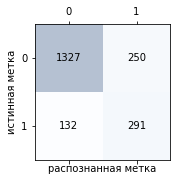

In [30]:
#Построим матрицу ошибок
model = RandomForestClassifier(random_state=12345, n_estimators=55, max_depth=7, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
confmat = confusion_matrix(y_true=target_test, y_pred=predicted_test)
fig, ax = plt.subplots(figsize= (2.5 , 2.5))
ax.matshow (confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
            s=confmat[i, j],
            va='center', ha='center')
plt.xlabel('распознанная метка')
plt.ylabel ('истинная метка')
plt.show ()

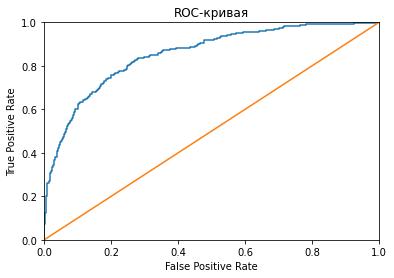

In [31]:
#Построим ROC-кривую и сравним её со случайной моделью
model = RandomForestClassifier(random_state=12345, n_estimators=55, max_depth=7, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr, [0, 1], [0, 1], linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [32]:
#Посчитаем AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Площадь под ROC-кривой:', auc_roc)

Площадь под ROC-кривой: 0.8536032896048548


##### Вывод


Наилучшая модель - модель случайного леса с балансировкой веса классов<br>
f1-мера наилучшей модели на тестовой выборке: 0.6107030430220357 <br>
Мы получили площадь под ROC-кривой: 0.8505901170939825
